In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.ar_model import ar_select_order

In [2]:
wti = pd.read_csv('/content/Cushing_OK_WTI_Spot_Price_FOB.csv',
                  skiprows=4)
wti = wti.rename(columns={'Cushing OK WTI Spot Price FOB Dollars per Barrel': 'WTI'})
wti['Month'] = pd.to_datetime(wti['Month'])
wti = wti[wti['Month'].dt.year >= 1990]
wti = wti.sort_values(by='Month', ascending=True)
wti

<ipython-input-2-3754e0c8a7de>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wti['Month'] = pd.to_datetime(wti['Month'])


,Month,WTI
424,1990-01-01,22.86
423,1990-02-01,22.11
422,1990-03-01,20.39
421,1990-04-01,18.43
420,1990-05-01,18.20
...,...,...
4,2025-01-01,75.74
3,2025-02-01,71.53
2,2025-03-01,68.24
1,2025-04-01,63.54


In [3]:
gasoline = pd.read_excel('/content/PET_PRI_GND_A_EPM0_PTE_DPGAL_M.xls', skiprows=2)
gasoline = gasoline.rename(columns={'U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)': 'Gasoline'})
gasoline['Date'] = pd.to_datetime(gasoline['Date'])
gasoline = gasoline[gasoline['Date'].dt.year >= 1990]
# gasoline = gasoline.sort_values(by='Date', ascending=False)
gasoline

,Date,Gasoline
0,1993-04-15,1.078
1,1993-05-15,1.100
2,1993-06-15,1.097
3,1993-07-15,1.078
4,1993-08-15,1.062
...,...,...
381,2025-01-15,3.196
382,2025-02-15,3.247
383,2025-03-15,3.223
384,2025-04-15,3.299


In [4]:
diesel = pd.read_csv('/content/U.S._No_2_Diesel_Retail_Prices.csv', skiprows=4)
diesel = diesel.rename(columns={'U.S. No 2 Diesel Retail Prices Dollars per Gallon': 'Diesel'})
diesel['Month'] = pd.to_datetime(diesel['Month'])
diesel = diesel[diesel['Month'].dt.year >= 1990]
diesel = diesel.sort_values(by='Month', ascending=True)
diesel

<ipython-input-4-515643ac9e3e>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  diesel['Month'] = pd.to_datetime(diesel['Month'])


,Month,Diesel
373,1994-04-01,1.107
372,1994-05-01,1.100
371,1994-06-01,1.103
370,1994-07-01,1.110
369,1994-08-01,1.123
...,...,...
4,2025-01-01,3.634
3,2025-02-01,3.675
2,2025-03-01,3.585
1,2025-04-01,3.567


In [5]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime.now()

dollar = web.DataReader("DTWEXBGS", 'fred', start, end)
dollar = dollar.resample('ME').mean()
dollar = dollar[dollar.index >= start]
dollar.reset_index(inplace=True)
dollar = dollar.rename(columns={'DTWEXBGS': 'Dollar'})
dollar

,DATE,Dollar
0,2006-01-31,100.000005
1,2006-02-28,100.211170
2,2006-03-31,100.428087
3,2006-04-30,99.743480
4,2006-05-31,97.511774
...,...,...
228,2025-01-31,129.041257
229,2025-02-28,128.066505
230,2025-03-31,126.486433
231,2025-04-30,124.455677


In [6]:
df = pd.concat([wti, gasoline['Gasoline']], axis=1)
df = df.dropna()
df = pd.concat([df, diesel['Diesel']], axis=1)
df = df.dropna()
df = pd.concat([df, dollar['Dollar']], axis=1)
df = df.dropna()
df = df.sort_values(by='Month', ascending=False)
df

,Month,WTI,Gasoline,Diesel,Dollar
0,2025-05-01,62.17,1.078,3.499,100.000005
1,2025-04-01,63.54,1.100,3.567,100.211170
2,2025-03-01,68.24,1.097,3.585,100.428087
3,2025-02-01,71.53,1.078,3.675,99.743480
4,2025-01-01,75.74,1.062,3.634,97.511774
...,...,...,...,...,...
228,2006-05-01,70.84,3.958,2.897,129.041257
229,2006-04-01,69.44,3.791,2.728,128.066505
230,2006-03-01,62.69,3.596,2.559,126.486433
231,2006-02-01,61.63,3.498,2.475,124.455677


In [7]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.sort_index(inplace=True)
df

,WTI,Gasoline,Diesel,Dollar
Month,,,,
2006-01-01,65.49,3.780,2.467,122.686910
2006-02-01,61.63,3.498,2.475,124.455677
2006-03-01,62.69,3.596,2.559,126.486433
2006-04-01,69.44,3.791,2.728,128.066505
2006-05-01,70.84,3.958,2.897,129.041257
...,...,...,...,...
2025-01-01,75.74,1.062,3.634,97.511774
2025-02-01,71.53,1.078,3.675,99.743480
2025-03-01,68.24,1.097,3.585,100.428087


In [8]:
df_log = np.log(df[['WTI', 'Gasoline', 'Diesel', 'Dollar']])
df_log.head()

,WTI,Gasoline,Diesel,Dollar
Month,,,,
2006-01-01,4.181897,1.329724,0.903003,4.809636
2006-02-01,4.121149,1.252191,0.906240,4.823950
2006-03-01,4.138202,1.279822,0.939617,4.840135
2006-04-01,4.240463,1.332630,1.003569,4.852550
2006-05-01,4.260424,1.375739,1.063676,4.860132


## **ADF test**

In [9]:
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test for {title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('-'*30)

for col in df_log.columns:
    adf_test(df_log[col], title=col)

ADF Test for WTI
ADF Statistic: -3.5703
p-value: 0.0064
------------------------------
ADF Test for Gasoline
ADF Statistic: -1.4412
p-value: 0.5624
------------------------------
ADF Test for Diesel
ADF Statistic: -3.0023
p-value: 0.0347
------------------------------
ADF Test for Dollar
ADF Statistic: -1.7294
p-value: 0.4160
------------------------------


## **KPSS test**

In [10]:
def kpss_test(series, title=''):
    result = kpss(series)
    print(f'KPSS Test for {title}')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('-'*30)

for col in df_log.columns:
    kpss_test(df_log[col])

KPSS Test for 
KPSS Statistic: 0.3215
p-value: 0.1000
------------------------------
KPSS Test for 
KPSS Statistic: 2.2484
p-value: 0.0100
------------------------------
KPSS Test for 
KPSS Statistic: 0.2939
p-value: 0.1000
------------------------------
KPSS Test for 
KPSS Statistic: 1.8830
p-value: 0.0100
------------------------------


<ipython-input-10-22e4624489b4>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)
<ipython-input-10-22e4624489b4>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)
<ipython-input-10-22e4624489b4>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)
<ipython-input-10-22e4624489b4>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)


## **differencing non stationary dataset**

In [12]:
df_diff = df_log[['Gasoline', 'Dollar']].diff().dropna()

def run_diff_stationarity_tests(series, name):
    adf_result = adfuller(series, autolag='AIC')  # ADF tests H0: unit root (I(1))
    # The kpss function returns (statistic, p-value, critical values, trend)
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_statistic = kpss_result[0]
    kpss_p_value = kpss_result[1] # Extract the p-value

    return {
        'Series': name,
        'ADF Statistic': round(adf_result[0], 4),
        'ADF p-value': round(adf_result[1], 4),
        'KPSS Statistic': round(kpss_statistic, 4),
        'KPSS p-value': round(kpss_p_value, 4)}

columns_to_test_diff = ['Gasoline', 'Dollar']
results_diff = [run_diff_stationarity_tests(df_diff[col], col) for col in columns_to_test_diff]
results_diff_df = pd.DataFrame(results_diff)

results_diff_df

<ipython-input-12-b89493a9ac78>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
<ipython-input-12-b89493a9ac78>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


,Series,ADF Statistic,ADF p-value,KPSS Statistic,KPSS p-value
0,Gasoline,-5.2710,0.0,0.0536,0.1
1,Dollar,-9.4397,0.0,0.1125,0.1


## **Johansen test**

In [13]:
df_coint = df_log[['Gasoline', 'Dollar']].dropna()

johansen_test = coint_johansen(df_coint, det_order=0, k_ar_diff=1)

johansen_results = {
    "Eigenvalues": johansen_test.eig,
    "Trace Statistic": johansen_test.lr1,
    "Trace 90% Crit Value": johansen_test.cvt[:, 0],
    "Trace 95% Crit Value": johansen_test.cvt[:, 1],
    "Trace 99% Crit Value": johansen_test.cvt[:, 2]}

# Engle-Granger (residual-based) test for WTI (I(0)) and Gasoline (I(1))
coint_stat, coint_pval, _ = coint(df_log['Gasoline'], df_log['WTI'])
johansen_results, (coint_stat, coint_pval)

({'Eigenvalues': array([0.06898772, 0.01025508]),
  'Trace Statistic': array([18.89368195,  2.38115362]),
  'Trace 90% Crit Value': array([13.4294,  2.7055]),
  'Trace 95% Crit Value': array([15.4943,  3.8415]),
  'Trace 99% Crit Value': array([19.9349,  6.6349])},
 (np.float64(-1.7585145115064857), np.float64(0.6496454021891674)))

In [14]:
coint_result = coint(df_log['Gasoline'], df_log['WTI'])
print(f"Statistic: {coint_result[0]}, p-value: {coint_result[1]}")

Statistic: -1.7585145115064857, p-value: 0.6496454021891674


## **Full TECM Gasoline model**

In [15]:
y = df_log['Gasoline']
X = sm.add_constant(df_log['Dollar'])
cointegration_model = OLS(y, X).fit()
residuals = cointegration_model.resid


resid_lag = residuals.shift(1)
ect_pos = resid_lag.where(resid_lag >= 0, 0)
ect_neg = resid_lag.where(resid_lag < 0, 0)

diff_df = df_log.diff().dropna()
diff_df['ECT_pos'] = ect_pos
diff_df['ECT_neg'] = ect_neg

diff_df = df_log.diff().dropna()
diff_df['ECT_pos'] = ect_pos
diff_df['ECT_neg'] = ect_neg

resid_lag_aligned = resid_lag[diff_df.index]

ect_pos = resid_lag_aligned.where(resid_lag_aligned >= 0, 0)
ect_neg = resid_lag_aligned.where(resid_lag_aligned < 0, 0)

diff_df['ECT_pos'] = ect_pos
diff_df['ECT_neg'] = ect_neg

vars_to_lag = diff_df[['Gasoline', 'WTI', 'Dollar']]
lagged_vars = lagmat(vars_to_lag, maxlag=1, trim='both')

lagged_df = pd.DataFrame(lagged_vars, columns=[f'{col}_lag1' for col in vars_to_lag.columns])

tecm_y = diff_df['Gasoline'].iloc[1:]

ect_pos_aligned = ect_pos.iloc[1:]
ect_neg_aligned = ect_neg.iloc[1:]

tecm_X_df = pd.DataFrame({
    'ECT_pos': ect_pos_aligned,
    'ECT_neg': ect_neg_aligned})

lagged_df.index = tecm_X_df.index

tecm_X = pd.concat([tecm_X_df, lagged_df], axis=1)
tecm_X = sm.add_constant(tecm_X)
tecm_model = OLS(tecm_y, tecm_X).fit(cov_type='HC3')
tecm_summary = tecm_model.summary()
tecm_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gasoline   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     5.787
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           4.77e-05
Time:                        06:14:20   Log-Likelihood:                 359.05
No. Observations:                 231   AIC:                            -706.1
Df Residuals:                     225   BIC:                            -685.5
Df Model:                           5                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0075      0.006      1.167      0.243      -0.005       0.020
ECT_pos          -0.1014      0.036     -2.787      0.005      -0.173      -0.030
ECT_neg           0.0137      0.029      0.473      0.636      -0.043       0.070
Gasoline_lag1     0.4744      0.097      4.867      0.000       0.283       0.665
WTI_lag1          0.0117      0.027      0.439      0.661      -0.041       0.064
Dollar_lag1       0.0444      0.215      0.206      0.836      -0.377       0.466
==============================================================================
Omnibus:                       43.458   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.492
Skew:                           0.606   Prob(JB):                     8.78e-46
Kurtosis:                       7.482   Cond. No.                         75.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## **Lag selection**

In [16]:
data = diff_df[['Gasoline', 'WTI', 'Dollar']].dropna()

model = VAR(data)
lag_results = model.select_order(maxlags=12)
print(lag_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.68      -18.63   7.743e-09      -18.66
1       -19.07     -18.89*   5.201e-09      -19.00
2      -19.14*      -18.81  4.886e-09*     -19.01*
3       -19.13      -18.66   4.937e-09      -18.94
4       -19.09      -18.49   5.139e-09      -18.84
5       -19.07      -18.33   5.239e-09      -18.77
6       -19.04      -18.16   5.414e-09      -18.68
7       -19.04      -18.02   5.399e-09      -18.63
8       -19.03      -17.88   5.436e-09      -18.57
9       -18.98      -17.69   5.734e-09      -18.46
10      -18.98      -17.55   5.748e-09      -18.40
11      -18.94      -17.36   6.007e-09      -18.30
12      -18.91      -17.20   6.169e-09      -18.22
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## **TECM with optimal lag**

In [17]:
vars_to_lag = diff_df[['Gasoline', 'WTI', 'Dollar']]
lagged_vars = lagmat(vars_to_lag, maxlag=2, trim='both')

lagged_df = pd.DataFrame(
    lagged_vars,
    columns=[f'{col}_lag1' for col in vars_to_lag.columns] +
            [f'{col}_lag2' for col in vars_to_lag.columns])

# Align residuals and ECT terms with the new lags
tecm_y = diff_df['Gasoline'].iloc[2:]
ect_pos_aligned = ect_pos.iloc[2:]
ect_neg_aligned = ect_neg.iloc[2:]

tecm_X_df = pd.DataFrame({
    'ECT_pos': ect_pos_aligned,
    'ECT_neg': ect_neg_aligned})

tecm_X_df.index = tecm_y.index
lagged_df.index = tecm_y.index

tecm_X = pd.concat([tecm_X_df, lagged_df], axis=1)
tecm_X = sm.add_constant(tecm_X)

tecm_model_updated = OLS(tecm_y, tecm_X).fit(cov_type='HC3')
print(tecm_model_updated.summary())

                            OLS Regression Results                            
Dep. Variable:               Gasoline   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4.436
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           5.32e-05
Time:                        06:14:20   Log-Likelihood:                 366.10
No. Observations:                 230   AIC:                            -714.2
Df Residuals:                     221   BIC:                            -683.3
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.006      0.508

## **Reduced feature model**

In [18]:
tecm_X_reduced = tecm_X[['const', 'ECT_pos', 'ECT_neg', 'Gasoline_lag1', 'Gasoline_lag2']]
tecm_model_reduced = OLS(tecm_y, tecm_X_reduced).fit(cov_type='HC3')
print(tecm_model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:               Gasoline   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     7.863
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           5.99e-06
Time:                        06:14:20   Log-Likelihood:                 365.65
No. Observations:                 230   AIC:                            -721.3
Df Residuals:                     225   BIC:                            -704.1
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0030      0.006      0.514

## **Wald Test**

In [19]:
print("Parameters of tecm_model_diesel:")
print(tecm_model_reduced.params.index)

# --- Test 1: Cointegration Symmetry (H0: lambda_pos = lambda_neg) ---
# This tests if the adjustment speed is the same for positive and negative deviations.
# The hypothesis is ECT_pos = ECT_neg, which is equivalent to ECT_pos - ECT_neg = 0.

hypothesis_symmetry = 'ECT_pos = ECT_neg'

wald_test_symmetry_result = tecm_model_reduced.wald_test(hypothesis_symmetry)

print("\n--- Wald Test for Cointegration Symmetry ---")
print("H0: lambda_pos = lambda_neg (Symmetric Adjustment)")
print(wald_test_symmetry_result)

# --- Test 2: Joint Significance of ECT terms (H0: lambda_pos = 0 and lambda_neg = 0) ---
hypothesis_joint_significance = 'ECT_pos = 0, ECT_neg = 0'

wald_test_joint_result = tecm_model_reduced.wald_test(hypothesis_joint_significance)

print("\n--- Wald Test for Joint Significance of ECT Terms ---")
print("H0: lambda_pos = 0 and lambda_neg = 0 (No Error Correction)")
print(wald_test_joint_result)

Parameters of tecm_model_diesel:
Index(['const', 'ECT_pos', 'ECT_neg', 'Gasoline_lag1', 'Gasoline_lag2'], dtype='object')

--- Wald Test for Cointegration Symmetry ---
H0: lambda_pos = lambda_neg (Symmetric Adjustment)
<Wald test (chi2): statistic=[[1.97568955]], p-value=0.15984524083664692, df_denom=1>

--- Wald Test for Joint Significance of ECT Terms ---
H0: lambda_pos = 0 and lambda_neg = 0 (No Error Correction)
<Wald test (chi2): statistic=[[4.70276115]], p-value=0.09523758859926032, df_denom=2>


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


## **Residuals plot**

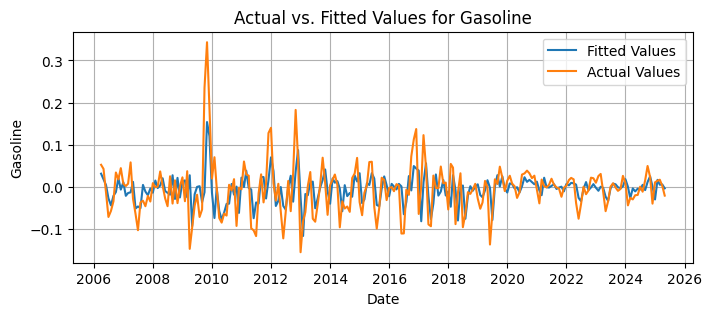

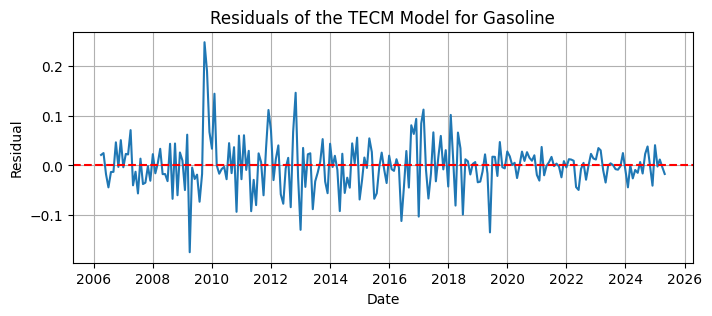

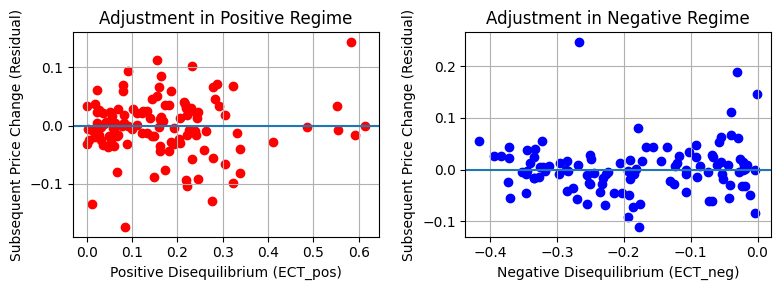

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(tecm_model_reduced.fittedvalues.index, tecm_model_reduced.fittedvalues, label='Fitted Values')

plt.plot(tecm_model_reduced.fittedvalues.index, tecm_model_reduced.model.endog, label='Actual Values')
plt.title('Actual vs. Fitted Values for Gasoline')
plt.xlabel('Date')
plt.ylabel('Gasoline')
plt.legend()
plt.grid(True)
plt.show()

# Residuals Plot
plt.figure(figsize=(8, 3))
plt.plot(tecm_model_reduced.resid.index, tecm_model_reduced.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of the TECM Model for Gasoline')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

# Relationship between ECT Terms and Subsequent Changes (using the data used to fit the model)
residuals_gasoline = tecm_model_reduced.resid
ect_pos_gasoline = tecm_X.loc[residuals_gasoline.index, 'ECT_pos']
ect_neg_gasoline = tecm_X.loc[residuals_gasoline.index, 'ECT_neg']

plt.figure(figsize=(8, 3))

# Positive ECT (Diesel above equilibrium)
plt.subplot(1, 2, 1)
plt.scatter(ect_pos_gasoline[ect_pos_gasoline > 0], residuals_gasoline[ect_pos_gasoline > 0], color='red')
plt.axhline(0)
plt.xlabel('Positive Disequilibrium (ECT_pos)')
plt.ylabel('Subsequent Price Change (Residual)')
plt.title('Adjustment in Positive Regime')
plt.grid()

# Negative ECT (Diesel below equilibrium)
plt.subplot(1, 2, 2)
plt.scatter(ect_neg_gasoline[ect_neg_gasoline < 0], residuals_gasoline[ect_neg_gasoline < 0], color='blue')
plt.axhline(0)
plt.xlabel('Negative Disequilibrium (ECT_neg)')
plt.ylabel('Subsequent Price Change (Residual)')
plt.title('Adjustment in Negative Regime')
plt.grid()

plt.tight_layout()
plt.show()

## **Full Diesel TECM model**

In [23]:
y = df_log['Diesel']
X = sm.add_constant(df_log['Dollar'])
cointegration_model = sm.OLS(y, X).fit()
df_log['resid_diesel'] = cointegration_model.resid

df_log['ECT'] = df_log['resid_diesel'].shift(1)
df_log['ECT_pos'] = df_log['ECT'].apply(lambda x: x if x >= 0 else 0)
df_log['ECT_neg'] = df_log['ECT'].apply(lambda x: x if x < 0 else 0)

df_log['D_Diesel'] = df_log['Diesel'].diff()
df_log['D_Diesel_lag1'] = df_log['D_Diesel'].shift(1)
df_log['D_Dollar'] = df_log['Dollar'].diff()
df_log['D_WTI'] = df_log['WTI'].diff()

tecm_df = df_log[['D_Diesel', 'ECT_pos', 'ECT_neg', 'D_Diesel_lag1', 'D_Dollar', 'D_WTI']].dropna()

y_tecm = tecm_df['D_Diesel']
X_tecm = sm.add_constant(tecm_df[['ECT_pos', 'ECT_neg', 'D_Diesel_lag1', 'D_Dollar', 'D_WTI']])
tecm_model_diesel = sm.OLS(y_tecm, X_tecm).fit()
tecm_model_diesel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               D_Diesel   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     50.82
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           4.22e-35
Time:                        06:14:21   Log-Likelihood:                 460.31
No. Observations:                 231   AIC:                            -908.6
Df Residuals:                     225   BIC:                            -888.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0066      0.004      1.553      0.122      -0.002       0.015
ECT_pos          -0.0434      0.021     -2.034      0.043      -0.085      -0.001
ECT_neg           0.0188      0.023      0.815      0.416      -0.027       0.064
D_Diesel_lag1     0.3967      0.047      8.454      0.000       0.304       0.489
D_Dollar         -0.0592      0.167     -0.353      0.724      -0.389       0.271
D_WTI             0.2414      0.021     11.317      0.000       0.199       0.283
==============================================================================
Omnibus:                       37.055   Durbin-Watson:                   2.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.435
Skew:                           0.432   Prob(JB):                     9.91e-43
Kurtosis:                       7.399   Cond. No.                         76.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
lag_selector = ar_select_order(diff_df['Diesel'], maxlag=12)
print(lag_selector.ar_lags)

[1]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## **Reduced model**

In [25]:
tecm_df_reduced = df_log[['D_Diesel', 'ECT_pos', 'D_Diesel_lag1', 'D_WTI']].dropna()
y_tecm_red = tecm_df_reduced['D_Diesel']
X_tecm_red = sm.add_constant(tecm_df_reduced[['ECT_pos', 'D_Diesel_lag1', 'D_WTI']])
tecm_red = sm.OLS(y_tecm_red, X_tecm_red).fit(cov_type='HC3')
tecm_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               D_Diesel   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     34.18
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           2.87e-18
Time:                        06:14:21   Log-Likelihood:                 459.95
No. Observations:                 231   AIC:                            -911.9
Df Residuals:                     227   BIC:                            -898.1
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0040      0.003      1.444      0.149      -0.001       0.009
ECT_pos          -0.0333      0.021     -1.596      0.111      -0.074       0.008
D_Diesel_lag1     0.3991      0.072      5.559      0.000       0.258       0.540
D_WTI             0.2379      0.050      4.736      0.000       0.139       0.336
==============================================================================
Omnibus:                       35.396   Durbin-Watson:                   2.336
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.526
Skew:                           0.385   Prob(JB):                     1.90e-41
Kurtosis:                       7.346   Cond. No.                         21.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## **Residuals plot**

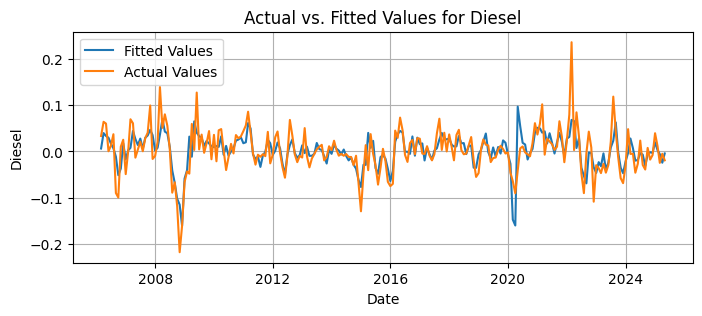

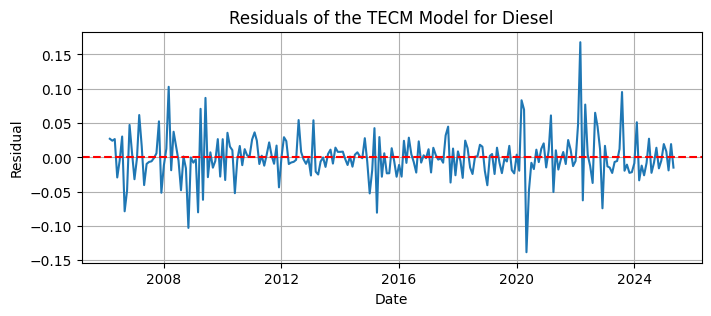

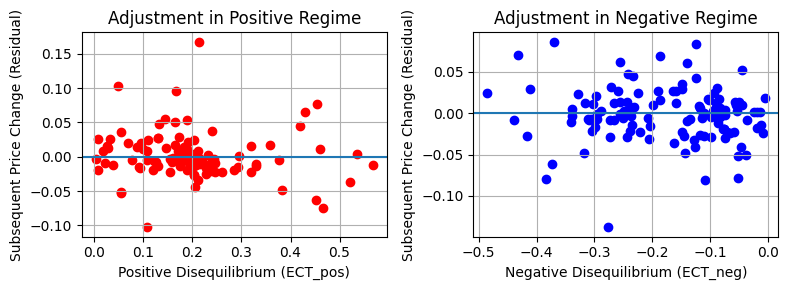

In [35]:
plt.figure(figsize=(8, 3))
plt.plot(tecm_model_diesel.fittedvalues.index, tecm_model_diesel.fittedvalues, label='Fitted Values')

plt.plot(tecm_model_diesel.fittedvalues.index, tecm_model_diesel.model.endog, label='Actual Values')
plt.title('Actual vs. Fitted Values for Diesel')
plt.xlabel('Date')
plt.ylabel('Diesel')
plt.legend()
plt.grid(True)
plt.show()

# Residuals Plot
plt.figure(figsize=(8, 3))
plt.plot(tecm_model_diesel.resid.index, tecm_model_diesel.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of the TECM Model for Diesel')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

# Relationship between ECT Terms and Subsequent Changes
residuals_diesel = tecm_model_diesel.resid
ect_pos_diesel = tecm_df.loc[residuals_diesel.index, 'ECT_pos']
ect_neg_diesel = tecm_df.loc[residuals_diesel.index, 'ECT_neg']

plt.figure(figsize=(8, 3))

# Positive ECT (Diesel above equilibrium)
plt.subplot(1, 2, 1)
plt.scatter(ect_pos_diesel[ect_pos_diesel > 0], residuals_diesel[ect_pos_diesel > 0], color='red')
plt.axhline(0)
plt.xlabel('Positive Disequilibrium (ECT_pos)')
plt.ylabel('Subsequent Price Change (Residual)')
plt.title('Adjustment in Positive Regime')
plt.grid()

# Negative ECT (Diesel below equilibrium)
plt.subplot(1, 2, 2)
plt.scatter(ect_neg_diesel[ect_neg_diesel < 0], residuals_diesel[ect_neg_diesel < 0], color='blue')
plt.axhline(0)
plt.xlabel('Negative Disequilibrium (ECT_neg)')
plt.ylabel('Subsequent Price Change (Residual)')
plt.title('Adjustment in Negative Regime')
plt.grid()

plt.tight_layout()
plt.show()

## **Wald Test**

In [26]:
print("Parameters of tecm_model_diesel:")
print(tecm_model_diesel.params.index)

hypothesis_symmetry = 'ECT_pos = ECT_neg'

wald_test_symmetry_result = tecm_model_diesel.wald_test(hypothesis_symmetry)

print("\n--- Wald Test for Cointegration Symmetry ---")
print("H0: lambda_pos = lambda_neg (Symmetric Adjustment)")
print(wald_test_symmetry_result)

hypothesis_joint_significance = 'ECT_pos = 0, ECT_neg = 0'

wald_test_joint_result = tecm_model_diesel.wald_test(hypothesis_joint_significance)

print("\n--- Wald Test for Joint Significance of ECT Terms ---")
print("H0: lambda_pos = 0 and lambda_neg = 0 (No Error Correction)")
print(wald_test_joint_result)

Parameters of tecm_model_diesel:
Index(['const', 'ECT_pos', 'ECT_neg', 'D_Diesel_lag1', 'D_Dollar', 'D_WTI'], dtype='object')

--- Wald Test for Cointegration Symmetry ---
H0: lambda_pos = lambda_neg (Symmetric Adjustment)
<F test: F=array([[2.50149984]]), p=0.11514259494248058, df_denom=225, df_num=1>

--- Wald Test for Joint Significance of ECT Terms ---
H0: lambda_pos = 0 and lambda_neg = 0 (No Error Correction)
<F test: F=array([[2.15472853]]), p=0.11832107578788176, df_denom=225, df_num=2>


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


## **Short run asymmetry**

In [27]:
df_log['It'] = df_log['ECT'].apply(lambda x: 1 if x >= 0 else 0)
df_log['I_comp'] = 1 - df_log['It']

# interaction terms for short-run asymmetry
df_log['D_Diesel_lag1_pos'] = df_log['D_Diesel_lag1'] * df_log['It']
df_log['D_Diesel_lag1_neg'] = df_log['D_Diesel_lag1'] * df_log['I_comp']
df_log['D_Dollar_pos'] = df_log['D_Dollar'] * df_log['It']
df_log['D_Dollar_neg'] = df_log['D_Dollar'] * df_log['I_comp']
df_log['D_WTI_pos'] = df_log['D_WTI'] * df_log['It']
df_log['D_WTI_neg'] = df_log['D_WTI'] * df_log['I_comp']

# model dataset
tecm_df_asym = df_log[['D_Diesel', 'ECT_pos', 'ECT_neg',
                       'D_Diesel_lag1_pos', 'D_Diesel_lag1_neg',
                       'D_Dollar_pos', 'D_Dollar_neg',
                       'D_WTI_pos', 'D_WTI_neg']].dropna()

# Estimate asymmetric short-run model
y_asym = tecm_df_asym['D_Diesel']
X_asym = sm.add_constant(tecm_df_asym.drop(columns=['D_Diesel']))
model_asym = sm.OLS(y_asym, X_asym).fit()
print(model_asym.summary())

                            OLS Regression Results                            
Dep. Variable:               D_Diesel   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     41.97
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           2.08e-40
Time:                        06:14:21   Log-Likelihood:                 479.42
No. Observations:                 231   AIC:                            -940.8
Df Residuals:                     222   BIC:                            -909.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0066      0.00

## Wald Test for short run model**

In [28]:
# Test for short-run asymmetry in Diesel lag
sr_asym_test_diesel = model_asym.wald_test('D_Diesel_lag1_pos = D_Diesel_lag1_neg')

# Test for short-run asymmetry in Dollar lag
sr_asym_test_dollar = model_asym.wald_test('D_Dollar_pos = D_Dollar_neg')

# Test for short-run asymmetry in WTI lag
sr_asym_test_wti = model_asym.wald_test('D_WTI_pos = D_WTI_neg')

print("Short-run Asymmetry Test: Diesel Lag")
print(sr_asym_test_diesel.summary())

print("\nShort-run Asymmetry Test: Dollar Lag")
print(sr_asym_test_dollar.summary())

print("\nShort-run Asymmetry Test: WTI Lag")
print(sr_asym_test_wti.summary())


Short-run Asymmetry Test: Diesel Lag
<F test: F=array([[0.450753]]), p=0.5026755738235729, df_denom=222, df_num=1>

Short-run Asymmetry Test: Dollar Lag
<F test: F=array([[2.20432845]]), p=0.13904232446309006, df_denom=222, df_num=1>

Short-run Asymmetry Test: WTI Lag
<F test: F=array([[38.13460341]]), p=3.11001946999635e-09, df_denom=222, df_num=1>


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
